<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Neural Nets for Sequential Data

-----
**OBJECTIVES**

- Explore Recurrent Architectures for sequential data
- Explore Convolutional Architectures for sequential data
- Use RNN's to model numeric time series data
- Use RNN's and CNN's to model text data
------

## The Recurrent Node

Compared to a convential neuron, our recurrent neuron will take in an output from the layer itself.  

<center>
   <img src = https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Recurrent_neural_network_unfold.svg/440px-Recurrent_neural_network_unfold.svg.png />
</center>



### The Network Architecture

```python
state_t = 0
for input_t in input_sequences:
    output_t = tanh(W@input_t + U@state_t + b)
    state_t = output_t
```



### A Basic Sequence of Stock Prices

To begin, let's bring in stock data from yahoo using the `pandas_datareader`. 

In [1]:
import pandas_datareader as pdr
from sklearn.model_selection import train_test_split

In [3]:
#!pip install pandas_datareader

In [4]:
#get apple stock
aapl = pdr.get_data_yahoo('AAPL')

In [5]:
#take a peek
aapl.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-02-08,23.924999,23.260000,23.282499,23.752501,216085600.0,22.125422
2016-02-09,23.985001,23.482500,23.572500,23.747499,177324800.0,22.120768
2016-02-10,24.087500,23.525000,23.980000,23.567499,169374400.0,21.953094
2016-02-11,23.680000,23.147499,23.447500,23.424999,200298800.0,21.820358
2016-02-12,23.625000,23.252501,23.547501,23.497499,161405600.0,21.887894


<AxesSubplot:xlabel='Date'>

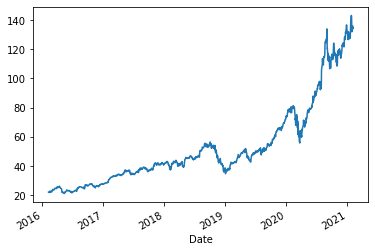

In [6]:
#plot the adjusted close
aapl['Adj Close'].plot()

<AxesSubplot:xlabel='Date'>

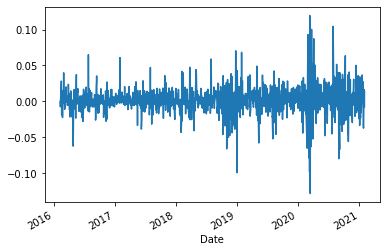

In [8]:
#look at the percent change
aapl['Adj Close'].pct_change().plot()

In [9]:
#determine X and y
aapl = aapl.pct_change()
aapl.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-02-08,NaN,NaN,NaN,NaN,NaN,NaN
2016-02-09,0.002508,0.009566,0.012456,-0.000211,-0.179377,-0.000210
2016-02-10,0.004273,0.001810,0.017287,-0.007580,-0.044835,-0.007580
2016-02-11,-0.016917,-0.016047,-0.022206,-0.006046,0.182580,-0.006046
2016-02-12,-0.002323,0.004536,0.004265,0.003095,-0.194176,0.003095


In [10]:
#drop missing
aapl.dropna(inplace = True)

In [12]:
import numpy as np

In [13]:
#train test split: no shuffle!
aapl = aapl.pct_change()
aapl.dropna(inplace = True)

X = aapl[['High', 'Low', 'Open', 'Volume']]
y = np.where(aapl['Close'] > 0, 1, 0)

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
aapl = aapl.pct_change()
aapl.dropna(inplace = True)

X = aapl[['High', 'Low', 'Open', 'Volume']]
y = np.where(aapl['Close'] > 0, 1, 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False)

In [16]:
X_train.head()

,High,Low,Open,Volume
Date,,,,
2016-02-09,0.002508,0.009566,0.012456,-0.179377
2016-02-10,0.004273,0.001810,0.017287,-0.044835
2016-02-11,-0.016917,-0.016047,-0.022206,0.182580
2016-02-12,-0.002323,0.004536,0.004265,-0.194176
2016-02-16,0.024868,0.017202,0.008812,0.215767


### Scaling
------

Per usual we need to scale our data for the network.

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
#instantiate
sscaler = StandardScaler()

In [19]:
#fit and transform
aapl = aapl.pct_change()
aapl.dropna(inplace = True)

X = aapl[['High', 'Low', 'Open', 'Volume']]
y = np.where(aapl['Close'] > 0, 1, 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False)


sscaler = StandardScaler()
x_train = sscaler.fit_transform(X_train)
x_test = sscaler.transform(X_test)

In [20]:
x_train.shape

(942, 4)

### `TimeSeriesGenerator`
-------
This creates stacks of sequenced data of which we specify the length of the sequences desired.

In [21]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [37]:
train_sequences = TimeseriesGenerator(x_train, y_train, length = 3)

In [38]:
batch_x, batch_y = train_sequences[0]

In [39]:
batch_x.shape

(128, 3, 4)

In [29]:
test_sequences = TimeseriesGenerator(x_test, y_test, length = 3)

### Model with `SimpleRNN`
--------

- 1 `SimpleRNN` layer
- 1 hidden `Dense` layer

In [30]:
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, GRU, Dense

In [36]:
model = Sequential()
model.add(SimpleRNN(8, input_shape = (3, 4)))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'bce', optimizer = 'adam', metrics = ['acc'])

history = model.fit(train_sequences, validation_data=test_sequences, 
                    epochs = 30, verbose = 0)

import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

### Sequential Models for Text
-------

Now, we use the Keras `Tokenizer` to preprocess our spam data and feed it through different architectures of sequential network models.

In [43]:
import pandas as pd
import numpy as np

In [44]:
from keras.preprocessing.text import Tokenizer

In [45]:
spam = pd.read_csv('data/sms_spam.csv')
spam.head()

,type,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ..."
4,spam,okmail: Dear Dave this is your final notice to...


In [46]:
X = spam.text
y = np.where(spam['type'] == 'spam', 1, 0)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22)

### `Tokenizer`
------
Here, we set the limit to the number of words at 500, then fit the texts, and finally transform our text to sequences of integer values with the `.texts_to_sequences`.  To assure the same length we use the `pad_sequences` function.  

In [53]:
tokenizer = Tokenizer(500)

tokenizer.fit_on_texts(X_train)

x_train = tokenizer.texts_to_sequences(X_train)
x_test = tokenizer.texts_to_sequences(X_test)

from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train, maxlen = 100)
x_test = pad_sequences(x_test, maxlen = 100)

In [54]:
x_train

array([[  0,   0,   0, ..., 350,   5, 179],
       [  0,   0,   0, ..., 121,  14,   6],
       [  0,   0,   0, ..., 251,  32,  57],
       ...,
       [  0,   0,   0, ...,  99, 323, 237],
       [  0,   0,   0, ...,  42,   2,  20],
       [  0,   0,   0, ..., 236, 267, 102]], dtype=int32)

### Model!
-------

In [55]:
from keras.layers import Embedding

In [58]:
model = Sequential()

model.add(Embedding(input_dim = tokenizer.num_words, output_dim = 64))#creates embeddings


model.add(SimpleRNN(16))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'bce', metrics = ['accuracy'], optimizer = 'adam')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 10)

### Improving the Model
-----

- `LSTM` layers
- `GRU` layers
- `recurrent_dropout`
- `dropout`
- `Bidirectional` layers

In [59]:
model = Sequential()

model.add(Embedding(input_dim = tokenizer.num_words, output_dim = 64))#creates embeddings


model.add(GRU(16))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'bce', metrics = ['accuracy'], optimizer = 'adam')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 10)

Epoch 1/10
131/131 [==============================] - 3s 26ms/step - loss: 0.2724 - accuracy: 0.9026 - val_loss: 0.1222 - val_accuracy: 0.9691
Epoch 2/10
131/131 [==============================] - 3s 24ms/step - loss: 0.0659 - accuracy: 0.9825 - val_loss: 0.0742 - val_accuracy: 0.9799
Epoch 3/10
131/131 [==============================] - 3s 25ms/step - loss: 0.0396 - accuracy: 0.9882 - val_loss: 0.0665 - val_accuracy: 0.9827
Epoch 4/10
131/131 [==============================] - 3s 25ms/step - loss: 0.0318 - accuracy: 0.9909 - val_loss: 0.0664 - val_accuracy: 0.9806
Epoch 5/10
131/131 [==============================] - 3s 25ms/step - loss: 0.0239 - accuracy: 0.9938 - val_loss: 0.0758 - val_accuracy: 0.9813
Epoch 6/10
131/131 [==============================] - 3s 26ms/step - loss: 0.0215 - accuracy: 0.9928 - val_loss: 0.0841 - val_accuracy: 0.9791
Epoch 7/10
131/131 [==============================] - 3s 25ms/step - loss: 0.0189 - accuracy: 0.9952 - val_loss: 0.0887 - val_accuracy: 0.9799

In [61]:
model = Sequential()

model.add(Embedding(input_dim = tokenizer.num_words, output_dim = 64))#creates embeddings


model.add(GRU(16, return_sequences = True))
model.add(GRU(16, return_sequences = True))
model.add(GRU(16))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'bce', metrics = ['accuracy'], optimizer = 'adam')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 1)

131/131 [==============================] - 10s 78ms/step - loss: 0.2600 - accuracy: 0.9189 - val_loss: 0.0949 - val_accuracy: 0.9741


In [62]:
model = Sequential()

model.add(Embedding(input_dim = tokenizer.num_words, output_dim = 64))#creates embeddings


model.add(GRU(16, return_sequences = True, dropout = 0.2, recurrent_dropout = 0.2))
model.add(GRU(16, return_sequences = True))
model.add(GRU(16))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'bce', metrics = ['accuracy'], optimizer = 'adam')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 1)

131/131 [==============================] - 13s 103ms/step - loss: 0.2709 - accuracy: 0.9201 - val_loss: 0.1007 - val_accuracy: 0.9719


In [63]:
from keras.layers import Bidirectional

In [64]:
model = Sequential()

model.add(Embedding(input_dim = tokenizer.num_words, output_dim = 64))#creates embeddings

model.add(Bidirectional(GRU(16)))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'bce', metrics = ['accuracy'], optimizer = 'adam')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 1)

131/131 [==============================] - 4s 32ms/step - loss: 0.2762 - accuracy: 0.9110 - val_loss: 0.0904 - val_accuracy: 0.9748


### Convolutional Networks in 1D
--------

In [65]:
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [66]:
model = Sequential()

model.add(Embedding(input_dim = tokenizer.num_words, output_dim = 64))#creates embeddings

model.add(Conv1D(64, 10, activation = 'relu'))
model.add(MaxPooling1D(4))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'bce', metrics = ['accuracy'], optimizer = 'adam')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 1)

131/131 [==============================] - 1s 8ms/step - loss: 0.3999 - accuracy: 0.8715 - val_loss: 0.3922 - val_accuracy: 0.8705


In [67]:
model = Sequential()

model.add(Embedding(input_dim = tokenizer.num_words, output_dim = 64))#creates embeddings


model.add(Conv1D(64, 10, activation = 'relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation = 'relu'))
model.add(GRU(32, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'bce', metrics = ['accuracy'], optimizer = 'adam')

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 10)

Epoch 1/10
131/131 [==============================] - 2s 16ms/step - loss: 0.2744 - accuracy: 0.8971 - val_loss: 0.1341 - val_accuracy: 0.9676
Epoch 2/10
131/131 [==============================] - 2s 14ms/step - loss: 0.0793 - accuracy: 0.9791 - val_loss: 0.0797 - val_accuracy: 0.9755
Epoch 3/10
131/131 [==============================] - 2s 15ms/step - loss: 0.0527 - accuracy: 0.9882 - val_loss: 0.0798 - val_accuracy: 0.9777
Epoch 4/10
131/131 [==============================] - 2s 14ms/step - loss: 0.0426 - accuracy: 0.9914 - val_loss: 0.0820 - val_accuracy: 0.9784
Epoch 5/10
131/131 [==============================] - 2s 14ms/step - loss: 0.0309 - accuracy: 0.9942 - val_loss: 0.0868 - val_accuracy: 0.9777
Epoch 6/10
131/131 [==============================] - 2s 15ms/step - loss: 0.0288 - accuracy: 0.9938 - val_loss: 0.0816 - val_accuracy: 0.9806
Epoch 7/10
131/131 [==============================] - 2s 15ms/step - loss: 0.0202 - accuracy: 0.9962 - val_loss: 0.0818 - val_accuracy: 0.9784